In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

inv = np.linalg.inv

In [368]:
filename = 'ios/rotation-through-g-field.csv'
fields = pd.read_csv('ios/shake-with-gps.csv').columns
filename = 'ios/z-bias-balance.csv'
(t, _, _,location_timestamp,
latitude, longitude, altitude,
 _, _, vertical_accuracy, horizontal_accuracy, _, 
at, ax, ay, az,
gt, gx, gy, gz,
_, magx, magy, magz,
_, _, alt, _,
) = pd.read_csv(filename)[fields].values.T[:,:4500:1]

t = pd.to_datetime(t)
t[-1] - t[0]

Timedelta('0 days 00:00:34.343000')

In [369]:
dt = ((t[-1] - t[0]) / (len(t) - 1)).value / 1e9

In [370]:
def R_(yaw, pitch, roll):
    """http://planning.cs.uiuc.edu/node102.html"""
    """Performs first roll, then pitch, then yaw"""
    """a : alpha, yaw"""
    """b: beta, pitch"""
    """r: gamma, roll"""
    ca = np.cos(yaw)
    cb = np.cos(pitch)
    cg = np.cos(roll)
    sa = np.sin(yaw)
    sb = np.sin(pitch)
    sg = np.sin(roll)
    
    
    yR = np.array([
        [ca, sa, 0],
        [-sa, ca, 0],
        [0, 0, 1]
    ])
    
    pR = np.array([
        [1, 0, 0],
        [0, cb, sb],
        [0, -sb, cb]
    ])
    
    rR = np.array([
        [cg, 0, -sg],
        [0, 1, 0],
        [sg, 0, cg]
    ])
    
    return rR @ pR @ yR
    return np.array([
        [ca*cg - sa*sb*sg, cg*sa + ca*sb*sg, -cb*sg],
        [-cb*sa, ca*cb, sb],
        [cg*sa*sb + ca*sg, -ca*cg*sb + sa*sg, cb*cg]
    ])

def get_yaw_pitch_roll_from_R(R):
    """https://math.stackexchange.com/a/2802520"""
    yaw = np.angle(-1j*R[1,0] + R[1,1])
    pitch = np.arcsin(R[1,2])
    roll = np.arctan(-R[0,2]/R[2,2])
    
    return yaw, pitch, roll

def h(mu):
    pitch, roll = mu
    return R_(0, pitch, roll) @ np.array([0, 0, -1])

In [371]:
def new_GPS(time_index):
    lat, lng, alt = (
        np.stack([latitude, longitude, altitude]).T[time_index]
    )
    earth_radius = 6.3781e6 # meter
    dy = (lat - latitude[0]) *  earth_radius
    dx = (lng - longitude[0]) * earth_radius * np.cos(latitude[0])
    if time_index == 0:
        return dx, dy, alt
    elif location_timestamp[time_index] == location_timestamp[time_index-1]:
        return None
    else:
        return dx, dy, alt

In [396]:
Q_acc = .02
Q_ang = .1 * dt
Q_acc_b = 0.00
Q_gyr_b = 0
initial_bias_uncertainty = .005

number_of_timesteps = len(t)
number_of_states = 12

R = np.array([
    [Q_acc**2, 0, 0],
    [0, Q_acc**2, 0],    
    [0, 0, Q_acc**2]
])

kalman_states = np.empty((number_of_timesteps, number_of_states)) * np.nan
kalman_errors = np.empty((number_of_timesteps, number_of_states)) * np.nan

I = np.identity(number_of_states)

# initialize state
# mu :
# [yaw, pitch, roll, rx, ry, rz, vx, vy, vz, axb, ayb, azb]
accel_bias = (-0.00234, 
               0.000132, 
              -0.00939)
accel_bias = (-0.0015945798565726007, 0.0008665717252466196, -0.010640301167092735)
accel_bias = (-0.0005734889762111468, 0.001090634786215037, -0.010731279613279767)
accel_bias = (-0.017106675059480415, -0.013349333222139262, -0.0017706018560563364)
mu = np.array([0, 0, 0, 0, 0, 0, 0,0,0, *accel_bias])
P = np.array([
    [np.pi, 0, 0,  0, 0, 0,  0, 0, 0,  0,0,0],
    [0, np.pi/40, 0,  0, 0, 0,  0, 0, 0, 0,0,0],
    [0, 0, np.pi/40,  0, 0, 0,  0, 0, 0, 0,0,0],    
    [0, 0, 0,  100, 0, 0,  0, 0, 0,  0,0,0],    
    [0, 0, 0,  0, 100, 0,  0, 0, 0,  0,0,0],
    [0, 0, 0,  0, 0, 100,  0, 0, 0,  0,0,0],
    [0, 0, 0,  0, 0, 0,  .1, 0, 0,  0,0,0],
    [0, 0, 0,  0, 0, 0,  0, .1, 0,  0,0,0],
    [0, 0, 0,  0, 0, 0,  0, 0, .1,  0,0,0],
    [0,0,0, 0,0,0, 0,0,0, initial_bias_uncertainty,0,0],
    [0,0,0, 0,0,0, 0,0,0, 0,initial_bias_uncertainty,0],
    [0,0,0, 0,0,0, 0,0,0, 0,0,initial_bias_uncertainty],
])**2

g = 9.81
da = .03

for time_index in range(number_of_timesteps):
    # Kalman step

    yaw, pitch, roll, rx, ry, rz, vx, vy, vz, axb, ayb, azb = mu
    ax_, ay_, az_ = np.stack([ax, ay, az]).T[time_index, :]
    
    a_norm = (
        (ax_ - axb)**2
        + (ay_ - ayb)**2
        + (az_ - azb )**2
    )**.5
    if False or (abs(a_norm - 1) < da 
            and 
            np.max(np.diag(P)[9:12]**.5) > .0008):
        Q_acc = .01
        is_calibrating = 1
        #print(np.max(np.diag(P)[9:12]**.5))
    else:
        Q_acc = .1
        is_calibrating = 0
    
    Q = np.array([
        [Q_ang, 0, 0,  0,0,0, 0,0,0, 0,0,0],  
        [0, Q_ang, 0,  0,0,0, 0,0,0, 0,0,0],   
        [0, 0, Q_ang,  0,0,0, 0,0,0, 0,0,0],

        [0,0,0,  0,0,0, 0,0,0, 0,0,0],
        [0,0,0,  0,0,0, 0,0,0, 0,0,0],
        [0,0,0,  0,0,0, 0,0,0, 0,0,0],

        [0,0,0,  0,0,0, (Q_acc*dt)**2,0,0, 0,0,0],
        [0,0,0,  0,0,0, 0,(Q_acc*dt)**2,0, 0,0,0],
        [0,0,0,  0,0,0, 0,0,(Q_acc*dt)**2, 0,0,0],

        [0,0,0,  0,0,0, 0,0,0, Q_acc_b**2,0,0],
        [0,0,0,  0,0,0, 0,0,0, 0,Q_acc_b**2,0],
        [0,0,0,  0,0,0, 0,0,0, 0,0,Q_acc_b**2],
    ])        
    
    def f(mu, u):
        gx, gy, gz, ax_, ay_, az_ = u
        dyaw = gz * dt
        dpitch = gx * dt
        droll = gy * dt
        
        yaw, pitch, roll, rx, ry, rz, vx, vy, vz, axb, ayb, azb = mu
        
        total_R = R_(dyaw, dpitch, droll) @ R_(yaw, pitch, roll)
        yaw, pitch, roll = get_yaw_pitch_roll_from_R(total_R)
        
        average_R = R_(dyaw/2, dpitch/2, droll/2) @ R_(yaw, pitch, roll)
        aX, aY, aZ = inv(average_R) @ np.array([ax_+axb, ay_+ayb, az_+azb]) * g
        
        rx += aX * dt ** 2 / 2 + vx * dt
        ry += aY * dt ** 2 / 2 + vy * dt
        rz += (aZ + g) * dt ** 2 / 2 + vz * dt
        
        vx += aX * dt
        vy += aY * dt
        vz += (aZ + g) * dt
        
        mu = np.array([yaw, pitch, roll,
                       rx, ry, rz,
                       vx, vy, vz,
                       axb, ayb, azb
                      ])
        
        return mu
    
    def h(mu):
        yaw, pitch, roll = mu[0:3]
        #        axb, ayb, azb = mu[0:3]
        return (R_(0, pitch, roll) @ np.array([0, 0, -1])) + mu[9:12]

    F = np.array([
        [1, 0, 0,  0, 0, 0,  0, 0, 0, 0,0,0],
        [0, 1, 0,  0, 0, 0,  0, 0, 0, 0,0,0],
        [0, 0, 1,  0, 0, 0,  0, 0, 0, 0,0,0],
        
        [0, 0, 0,  1, 0, 0,  dt, 0, 0, 0,0,0],
        [0, 0, 0,  0, 1, 0,  0, dt, 0, 0,0,0],
        [0, 0, 0,  0, 0, 1,  0, 0, dt, 0,0,0],
        
        [0, 0, 0,  0, 0, 0,  1, 0, 0, 0,0,0],
        [0, 0, 0,  0, 0, 0,  0, 1, 0, 0,0,0],
        [0, 0, 0,  0, 0, 0,  0, 0, 1, 0,0,0],
    
        [0, 0, 0,  0, 0, 0,  0, 0, 0, 1,0,0],
        [0, 0, 0,  0, 0, 0,  0, 0, 0, 0,1,0],
        [0, 0, 0,  0, 0, 0,  0, 0, 0, 0,0,1],
    ])    
    
    z = np.array([ax_, ay_, az_])
    
    """Calculate pitch and roll from gravity vector"""
    pitch, roll = mu[1:3]        
    cb = np.cos(pitch)
    sb = np.sin(pitch)
    cg = np.cos(roll)
    sg = np.sin(roll)
    
    H = (np.array([
        [0, -sb*sg, cb*cg,  0,0,0, 0,0,0, is_calibrating,0,0],
        [0, -cb, 0,         0,0,0, 0,0,0, 0,is_calibrating,0],
        [0, sb*cg, cb*sg,   0,0,0, 0,0,0, 0,0,is_calibrating]     
    ]))

    # Predict
    u = np.vstack([gx, gy, gz, ax, ay, az]).T[time_index]
    mu_model = f(mu, u)
    P = F @ P @ F.T + Q

    # Update IMU based on gravity vector
    y = z - h(mu) 
    K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
    mu = mu_model + K @ y
    P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
    y = z - H @ mu # post-fit residual
    
    # If new GPS is available, update based on GPS position
    try:
        raise TypeError
        z = np.array(new_GPS(time_index))
        H_GPS = np.array([
            [0,0,0, 1,0,0, 0,0,0, 0,0,0],
            [0,0,0, 0,1,0, 0,0,0, 0,0,0],
            [0,0,0, 0,0,1, 0,0,0, 0,0,0]
        ])
        d_vertical = vertical_accuracy[time_index]
        d_horizontal = horizontal_accuracy[time_index]
        R_GPS = np.array([
            [d_horizontal, 0,0],
            [0,d_horizontal, 0],
            [0, 0,d_vertical]
        ])**2
        y = z - H_GPS @ mu
        K = P @ H_GPS.T @ np.linalg.inv(R_GPS + H_GPS @ P @ H_GPS.T)
        mu = mu + K @ y
        P = (I - K @ H_GPS) @ P @ (I - K @ H_GPS).T + K @ R_GPS @ K.T        
        y = z - H_GPS @ mu
        print('update', y)
        #print('K', K)
    except TypeError:
        pass
    
    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


In [397]:
yaw, pitch, roll, rx, ry, rz ,vx, vy, vz, axb, ayb, azb = kalman_states.T

In [417]:
(np.mean(az[2100:3000]) + np.mean(az[0:1500])) / 2

-0.00858712938096784

In [414]:
np.mean(az[0:1500])

-1.0111298624674478

-1.0111298624674478

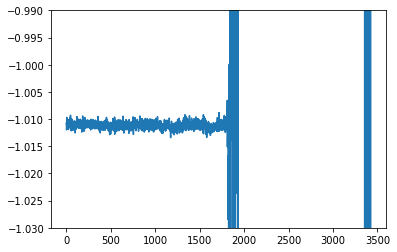

In [409]:
plt.plot(az)
plt.ylim(-1.03, -.99)
np.mean(az[0:1500])

(0.94, 1.06)

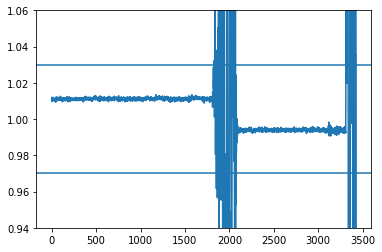

In [402]:
a_norm = ((az)**2 + (ay)**2 + (ax)**2)**.5
plt.plot(a_norm)
plt.axhline(1 + da)
plt.axhline(1 - da)
plt.ylim(1-2*da, 1+2*da)

-0.19873619023933334
-0.1863696717791691


(-1.1, 1.1)

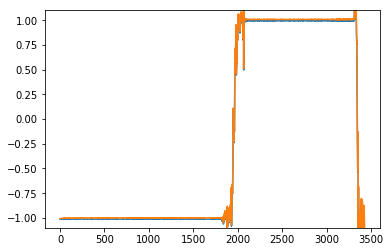

In [399]:
plt.plot(az)
plt.plot(az - azb)
print(np.mean(az))
print(np.mean(az - azb))
plt.ylim(-1.1, 1.1)

0.005944783255557886
-0.13815062708763642


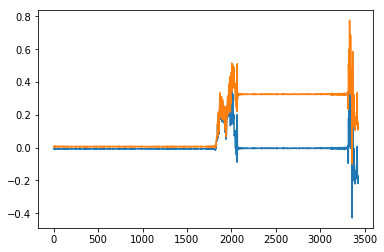

In [400]:
plt.plot(ay)
plt.plot(ay - ayb)
print(np.mean(ay))
print(np.mean(ay + ayb))

-0.022747835683029526
0.07081548105187756


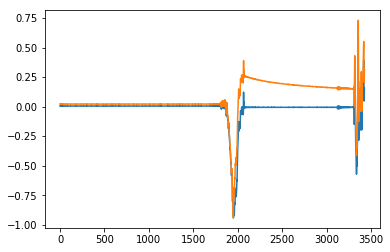

In [391]:
plt.plot(ax)
plt.plot(ax - axb)
print(np.mean(ax))
print(np.mean(ax - axb))

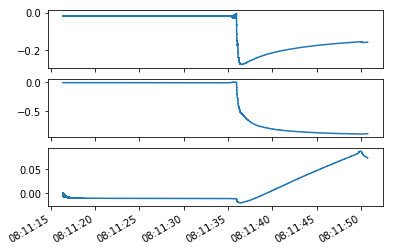

In [392]:
axbe, aybe, azbe = kalman_errors[:, 9:12].T
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
ax1.errorbar(t, axb, axbe)
ax2.errorbar(t, ayb, aybe)
ax3.errorbar(t, azb, azbe)
fig.autofmt_xdate()

(0, 0.005196271614524338)

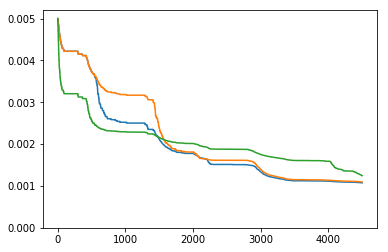

In [367]:
plt.plot(axbe)
plt.plot(aybe)
plt.plot(azbe)
plt.ylim(0,)

In [350]:
axb[-1], ayb[-1], azb[-1]

(-0.017106675059480415, -0.013349333222139262, -0.0017706018560563364)

In [258]:
ayb[-1]

0.0010635108846278486

In [259]:
axb[-1]

-0.0038821390838254663

In [189]:
t

DatetimeIndex(['2020-03-23 07:29:30.981000-07:00',
               '2020-03-23 07:29:30.982000-07:00',
               '2020-03-23 07:29:30.983000-07:00',
               '2020-03-23 07:29:30.986000-07:00',
               '2020-03-23 07:29:30.996000-07:00',
               '2020-03-23 07:29:31.006000-07:00',
               '2020-03-23 07:29:31.016000-07:00',
               '2020-03-23 07:29:31.038000-07:00',
               '2020-03-23 07:29:31.039000-07:00',
               '2020-03-23 07:29:31.047000-07:00',
               ...
               '2020-03-23 07:30:06.210000-07:00',
               '2020-03-23 07:30:06.220000-07:00',
               '2020-03-23 07:30:06.230000-07:00',
               '2020-03-23 07:30:06.240000-07:00',
               '2020-03-23 07:30:06.259000-07:00',
               '2020-03-23 07:30:06.260000-07:00',
               '2020-03-23 07:30:06.270000-07:00',
               '2020-03-23 07:30:06.280000-07:00',
               '2020-03-23 07:30:06.290000-07:00',
            

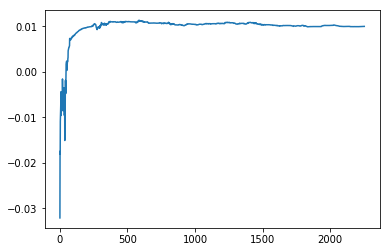

In [65]:
plt.plot(azb)

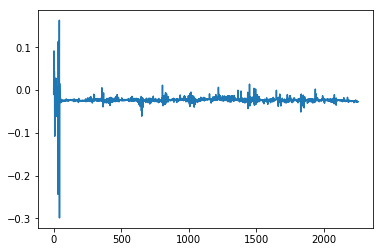

In [49]:
plt.plot(roll)

In [40]:
gps_coords = np.array([
    (t[i], *new_GPS(i)) for i in range(len(t)) if new_GPS(i)
])

In [331]:
gps_t, dx, dy, dz = gps_coords.T

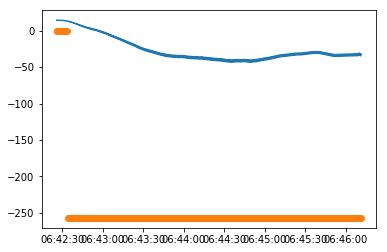

In [332]:
plt.plot(t, rz)
plt.plot(gps_t, dx, 'o')

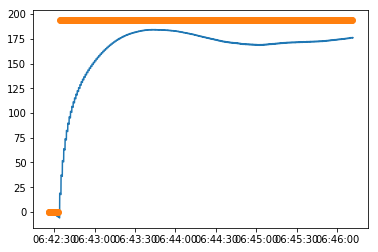

In [333]:
plt.plot(t, ry)
plt.plot(gps_t, dy, 'o')

In [98]:
np.around(h((.5, 0)), 2)

ValueError: not enough values to unpack (expected 3, got 2)

In [619]:
np.around(h((np.pi+.2, 0)), 4)

array([0.    , 0.1987, 0.9801])

In [620]:
np.around(h((.2, 0)), 4)

array([ 0.    , -0.1987, -0.9801])

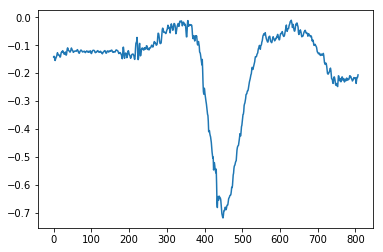

In [621]:
plt.plot(ay)

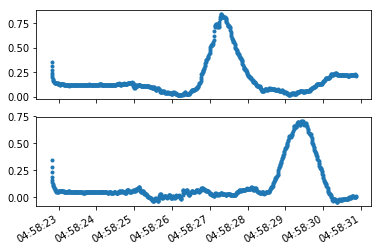

In [622]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

pitch = kalman_states[:, 0]
roll = kalman_states[:, 1]
ax1.plot(t, pitch, '.')
ax2.plot(t, roll, '.')
fig.autofmt_xdate()

In [623]:
accel_only = kalman_states.copy()

In [624]:
Q_acc = .01
Q_ang = .0001 * dt

number_of_timesteps = len(t)
number_of_states = 3

Q = np.array([
    [Q_ang, 0, 0],  
    [0, Q_ang, 0],   
    [0, 0, Q_ang],   
])    

R = np.array([
    [Q_acc, 0, 0],
    [0, Q_acc, 0],    
    [0, 0, Q_acc]
]) ** 2    

kalman_states = np.empty((number_of_timesteps, number_of_states)) * np.nan
kalman_errors = np.empty((number_of_timesteps, number_of_states)) * np.nan

I = np.identity(number_of_states)

# initialize state
mu = np.array([np.pi/8, np.pi/8, 0])
P = np.array([
    [Q_ang, 0, 0],
    [0, Q_ang, 0],
    [0, 0, Q_ang],    
])
for time_index in range(number_of_timesteps):
    # Kalman step

    pitch, roll, yaw = mu     
    ax_, ay_, az_ = np.stack([ax, ay, az]).T[time_index, :]
    
    def f(mu, u):
        gx, gy, gz = u
        dyaw = gz * dt
        dpitch = gx * dt
        droll = gy * dt
        
        pitch, roll, yaw = mu
        
        total_R = R_(dyaw, dpitch, droll) @ R_(yaw, pitch, roll)
        yaw, pitch, roll = get_yaw_pitch_roll_from_R(total_R)
        mu = np.array([pitch, roll, yaw])
        
        return mu
    
    def h(mu):
        pitch, roll, yaw = mu
        return R_(0, pitch, roll) @ np.array([0, 0, -1])

    F = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])    
    
    z = np.array([ax_, ay_, az_])
    
    cb = np.cos(pitch)
    sb = np.sin(pitch)
    cg = np.cos(roll)
    sg = np.sin(roll)
    
    H = -(np.array([
        [sb*sg, -cb*cg],
        [cb, 0],
        [-sb*cg, -cb*sg]     
    ]))

    # Predict
    u = np.vstack([gx, gy, gz]).T[time_index]
    mu_model = f(mu, u)
    P = F @ P @ F.T + Q

    # Update
    #y = z - h(mu)
    #K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
    mu = mu_model #+ K @ y
    #P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
    #y = z - H @ mu # post-fit residual

    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5

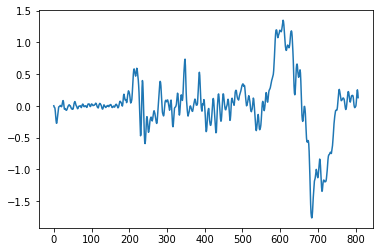

In [625]:
plt.plot(gy)

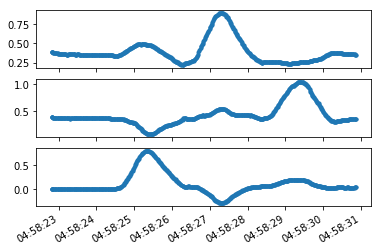

In [626]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

pitch = kalman_states[:, 0]
roll = kalman_states[:, 1]
yaw = kalman_states[:, 2]
ax1.plot(t, pitch, '.')
ax2.plot(t, roll, '.')
ax3.plot(t, yaw, '.')
fig.autofmt_xdate()

In [627]:
gyro_only = kalman_states.copy()

In [628]:
Q_acc = .001
Q_ang = .0001 * dt

number_of_timesteps = len(t)
number_of_states = 3

Q = np.array([
    [Q_ang, 0, 0],  
    [0, Q_ang, 0],   
    [0, 0, Q_ang],   
])    

R = np.array([
    [Q_acc, 0, 0],
    [0, Q_acc, 0],    
    [0, 0, Q_acc]
]) ** 2    

kalman_states = np.empty((number_of_timesteps, number_of_states)) * np.nan
kalman_errors = np.empty((number_of_timesteps, number_of_states)) * np.nan

I = np.identity(number_of_states)

# initialize state
mu = np.array([np.pi/8, np.pi/8, 0])
P = np.array([
    [Q_ang, 0, 0],
    [0, Q_ang, 0],
    [0, 0, Q_ang],    
])
for time_index in range(number_of_timesteps):
    # Kalman step

    pitch, roll, yaw = mu     
    ax_, ay_, az_ = np.stack([ax, ay, az]).T[time_index, :]
    
    def f(mu, u):
        gx, gy, gz = u
        dyaw = gz * dt
        dpitch = gx * dt
        droll = gy * dt
        
        pitch, roll, yaw = mu
        
        total_R = R_(dyaw, dpitch, droll) @ R_(yaw, pitch, roll)
        yaw, pitch, roll = get_yaw_pitch_roll_from_R(total_R)
        mu = np.array([pitch, roll, yaw])
        
        return mu
    
    def h(mu):
        pitch, roll, yaw = mu
        return R_(0, pitch, roll) @ np.array([0, 0, -1])

    F = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])    
    
    z = np.array([ax_, ay_, az_])
    
    cb = np.cos(pitch)
    sb = np.sin(pitch)
    cg = np.cos(roll)
    sg = np.sin(roll)
    
    H = -(np.array([
        [sb*sg, -cb*cg, 0],
        [cb, 0, 0],
        [-sb*cg, -cb*sg, 0]     
    ]))

    # Predict
    u = np.vstack([gx, gy, gz]).T[time_index]
    mu_model = f(mu, u)
    P = F @ P @ F.T + Q

    # Update
    y = z - h(mu)
    K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
    mu = mu_model + K @ y
    P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
    y = z - H @ mu # post-fit residual

    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5

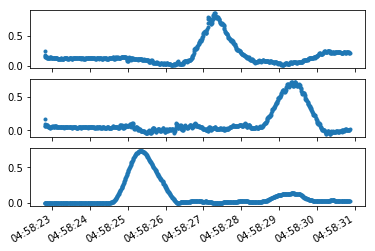

In [629]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

pitch = kalman_states[:, 0]
roll = kalman_states[:, 1]
yaw = kalman_states[:, 2]
ax1.plot(t, pitch, '.')
ax2.plot(t, roll, '.')
ax3.plot(t, yaw, '.')
fig.autofmt_xdate()

In [630]:
both = kalman_states.copy()

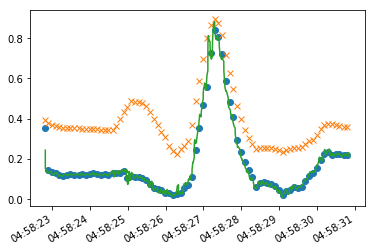

In [631]:
fig = plt.figure()
plt.plot(t[::10], accel_only[:, 0][::10], 'o')
plt.plot(t[::10], gyro_only[:, 0][::10], 'x')
plt.plot(t, both[:, 0])
fig.autofmt_xdate()

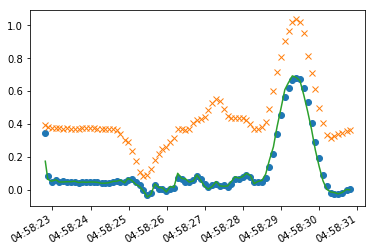

In [635]:
fig = plt.figure()
plt.plot(t[::10], accel_only[:, 1][::10], 'o')
plt.plot(t[::10], gyro_only[:, 1][::10], 'x')
plt.plot(t[::10], both[:, 1][::10])
fig.autofmt_xdate()